In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import networkx as nx
import xarray as xr
from typing import Union, Set, Dict
import matplotlib.ticker as ticker
from datetime import datetime

In [2]:
def import_HYPE_output(file_path: str
) -> pd.DataFrame:
    ''' Returns DataFrame after reading the HYPE output .txt file, the first row is dropped because it 
    contains the labels.
        
    Parameters
    ----------
    file_path: str
        Path to the .txt file to be converted
                
    Outputs
    ----------
    df: DataFrame
        DataFrame containing the info from the .txt file
    '''
    try:
        # Read the .txt file and create a DataFrame
        df = pd.read_csv(file_path, delimiter='\t',skiprows=1)  # Assuming tab-separated values in the file
        
        # Create a new DataFrame with only the first two columns
        df_new = df.iloc[:, :2]
        
        # Set the first column as the index (column with index 0)
        df_new.set_index(df.columns[0], inplace=True)
        
        # Name the index and the first column
        df_new = df_new.rename_axis('dates').rename(columns={df.columns[0]: 'flow (cms)'})
        
        # Return the DataFrame
        return df_new
    except FileNotFoundError:
        print("File not found!")
    except Exception as e:
        print("An error occurred:", e)

In [3]:
def import_HYPE_rout(file_path: str
) -> pd.DataFrame:
    ''' Returns DataFrame after reading the HYPE output .txt file, the first row is dropped because it 
    contains the labels.
        
    Parameters
    ----------
    file_path: str
        Path to the .txt file to be converted
                
    Outputs
    ----------
    df: DataFrame
        DataFrame containing the info from the .txt file
    '''
    try:
        # Read the .txt file and create a DataFrame
        df = pd.read_csv(file_path, delimiter='\t',skiprows=1)  # Assuming tab-separated values in the file
        
        # Create a new DataFrame with only the first three columns
        df_new = df.iloc[:, :3]

        # Drop the middle column using index
        df_new = df_new.drop(df.columns[1], axis=1)
        
        # Replace -9999 values with 0 for plot
        df_new = df_new.replace(-9999, 0)
        
        # Set the first column as the index (column with index 0)
        df_new.set_index(df.columns[0], inplace=True)
        
        # Name the index and the first column
        df_new = df_new.rename_axis('dates').rename(columns={df.columns[0]: 'flow (cms)'})
        
        # Return the DataFrame
        return df_new
    except FileNotFoundError:
        print("File not found!")
    except Exception as e:
        print("An error occurred:", e)

In [4]:
def import_Temp_Prec(file_path: str
) -> pd.DataFrame:
    ''' Returns DataFrame after reading Temperature or Precipitaiton.txt file. The IDs are removed from 
    the index and converted to int in order to sort them against a set of int later. 
        
    Parameters
    ----------
    file_path: str
        Path to the .txt file to be converted
                
    Outputs
    ----------
    df: DataFrame
        DataFrame containing the info from the .txt file
    '''
    try:
        # Read the .txt file and create a DataFrame
        df = pd.read_csv(file_path, delimiter='\t')  # Assuming tab-separated values in the file

        # remove IDs from the index
        df = df.reset_index()
        df.loc[-1] = df.columns
        df.sort_index(inplace=True)
        df.drop('index', axis=1, inplace=True)
        
        # convert IDs to int ignoring the first column
        df.iloc[0, 1:] = df.iloc[0, 1:].astype(int)
        
            # Reset the index of the DataFrame
        df = df.reset_index(drop=True)
        
        df = df.iloc[8767:13150]
        

        # Return the DataFrame
        return df
    
    except FileNotFoundError:
        print("File not found!")
    except Exception as e:
        print("An error occurred:", e)

In [5]:
def dnrc_read_csv_to_dataframe(
    file_path: str,                             
    start_date: str, 
    end_date: str, 
    column_index: int
) -> pd.DataFrame:
    """
    Read a CSV file, trim it based on start and end dates and a column index,
    and save the trimmed data to a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.
    - start_date (str, optional): The start date for trimming the data. Format: 'YYYY-MM-DD'.
    - end_date (str, optional): The end date for trimming the data. Format: 'YYYY-MM-DD'.
    - column_index (int, optional): The index number of the column to include in the trimmed DataFrame.

    Returns:
    - df (pandas.DataFrame): The trimmed DataFrame containing the specified data from the CSV file.
    """

    # Check if the file_path is valid
    try:
        open(file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"File '{file_path}' not found.")

    # Read the CSV file
    try:
        df = pd.read_csv(file_path, skiprows=6)
    except Exception as e:
        raise Exception(f"Error reading CSV file: {str(e)}")

    # Trim the DataFrame based on start and end dates
    if start_date and end_date:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
        df = df[(df.iloc[:, 0] >= start_date) & (df.iloc[:, 0] <= end_date)]

    # Trim the DataFrame based on column index
    if column_index is not None:
        df = df.iloc[:, [0, column_index]]
        
    # Convert flows from cfs to cms
    df.iloc[:, 1] = df.iloc[:, 1] * 0.0283168    # Convert cfs to cms
    
    # Set the first column as the index (column with index 0)
    df.set_index(df.columns[0], inplace=True)
    
    # Name the index and the first column
    df = df.rename_axis('dates').rename(columns={df.columns[0]: 'nat flow (cms)'})

    return df

In [6]:
def shapefile_ID(
    modifiedcat= str,
    riv= str
) -> gpd.GeoDataFrame:
    
    '''
    Reads the modified catchment shapefile where IDs have been assigned to all rivers and the river
    shapefile. It then concatinates the extra river IDs with the river shapefile. It then extracts 
    the seg_nhm and ds_nhm from the river shapefile and returns those two columns in a geodataframe. 
    That information can then be used to find precipitation at a given ID. 
    
    Parameters
    ----------
    modifiedcat: str
        Path to the modified catchment shapefile where the river ID of 0 have been replaced with IDs
    riv: str
        Path to the river shapefile
    
    
    Returns
    --------
    gpd: GeoDataFrame
        Geodataframe with the river IDs and corresponding downriver ID 
    
    '''
    
    # Read the modified catchment shapefile
    modifiedcat = gpd.read_file(modifiedcat)
    # Read the river shapefile
    riv = gpd.read_file(riv)
    
    # Sort the GeoDataFrame by a specific column
    sorted_modifiedcat = modifiedcat.sort_values(by='seg_nhm')
    sorted_riv = riv.sort_values(by='seg_nhm')
    
    # Select the specific rows based on the range in a column
    selected_rows = modifiedcat[(modifiedcat['seg_nhm'] >= 58662 )]
    
    # Concatenate the selected rows with the river shapefile
    merged_data = pd.concat([riv, selected_rows], ignore_index=True)

    # Convert the merged data to a GeoDataFrame
    merged_riv = gpd.GeoDataFrame(merged_data, crs=riv.crs)
    
    #Fill Na in the data
    merged_riv=merged_riv.fillna(0)
    
    # Assuming you have a GeoDataFrame named 'gdf'
    merged_riv['seg_nhm'] = merged_riv['seg_nhm'].astype(int)
    merged_riv['ds_seg_nhm'] = merged_riv['ds_seg_nhm'].astype(int)
    
    return merged_riv

From Kasra: 

In [7]:
def find_upstream(
    gdf: gpd.GeoDataFrame,
    target_id: str,
    main_id: str,
    ds_main_id: str,
) -> Set:
    '''Find "ancestors" or upstream segments in a river network given
    in the from of a geopandas.GeoDataFrame `gdf`
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    target_id: str, int, or any other data type as included in `gdf`
        Indicating the target ID anscestor or upstream of which is
        desired
    main_id: str
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    
    Returns
    -------
    nodes: list
        IDs of nodes being upstream or anscestor of the `target_id`
    
    '''
    # creating a DiGraph out of `gdf` object
    riv_graph = nx.from_pandas_edgelist(gdf, source=main_id, target=ds_main_id, create_using=nx.DiGraph)
    
    # return nodes in a list
    nodes = nx.ancestors(riv_graph, target_id)

    return nodes

In [8]:
def upstream_precipitation(
    df: pd.DataFrame, 
    columns: set, 
    target_id: int
) -> pd.DataFrame:
    '''
    Finds total precipitation at a station by summing the daily precipitation from all of it's upstream
    rivers. This returns a DataFrame with the dates in one column and the sum of precipitation at the 
    target ID in another column.
    
    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame containing the Precipitation data (pobs.txt in hype)
    columns: set
        Set of column names (station IDs) that are upstream of target_id and must be summed
    target_id: int
        Target ID for analysis. This will be included in the sum
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with dates in the first column and summed precipitation values for the 
        target ID in the second column
    '''
    # Filter columns by including the first one (dates), checking against upstream lists and target_id
    filtered_columns = [col for col in df.columns[1:] if int(col) in columns or int(col) == target_id]
        
    # Sum precipitation values for each date from row 1 onwards
    summed_precipitation = df.iloc[1:, 1:][filtered_columns].sum(axis=1)
        
    # Create a new DataFrame with dates and summed precipitation
    result_df = pd.DataFrame({'dates': df.iloc[1:, 0], str(target_id): summed_precipitation})
    
        # Set the 'dates' column as the index
    result_df.set_index('dates', inplace=True)

    return result_df

In [9]:
def plot_hydrograph_with_precipitation1(
    df1: pd.DataFrame, 
    df2: pd.DataFrame,  
    station_id: int
):
    """
    Plots hydrographs for computed flow and natural flow on top of each other and precipitation as an 
    upside-down bar plot above them.

    Args:
        df1: pd.DataFrame 
            Dataframe containing computed flow data.
        df2: pd.DataFrame
            Dataframe containing natural flow data.
        station_id: int 
            Station ID to be added to the plot title.
    """
    
        # Convert index to datetime format
    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    
    # Create a new figure and axis with a larger size
    fig, ax = plt.subplots(figsize=(15, 10))
    
            # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)

    # Plot the first hydrograph
    ax.plot(df1.index, df1.iloc[:, 0], color='blue', label='Simulated Hydrograph', alpha=0.7, linestyle='-')
    ax.set_ylabel('Hydrograph (m$^3$/s)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
        
    # Add minor ticks to the primary y-axis
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    # Create a second y-axis for precipitation
    ax2 = ax.twinx()

    # Plot the second hydrograph on the left y-axis
    ax.plot(df2.index, df2.iloc[:, 0], color='red', label='Observed Hydrograph', alpha=0.7, linestyle='-')
    ax.set_ylabel('Hydrograph (m$^3$/s)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Invert the y-axis for precipitation
    ax2.invert_yaxis()

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title('58308 Milk River at Eastern Crossing', fontsize=16)
    
        # Add KGE value to the upper right corner of the plot
    ax.text(0.85, 0.9,'Calibration KGE = 0.31 \n Validation KGE = 0.62', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    # Adjust x-axis tick labels by year
    years = pd.DatetimeIndex(df1.index).year
    ax.set_xticks(df1.index)
    ax.set_xticklabels(years, rotation=45, ha='right')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
        # Add minor ticks to the x-axis (every month)
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    # Flip the right y-axis scale
   # ax2.invert_yaxis()

    # Combine the legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [10]:
def plot_hydrograph_with_precipitation(
    df1: pd.DataFrame, 
    df2: pd.DataFrame,  
    station_id: int,
    start_date=None,
    end_date=None,
    save_path=None
):
    """
    Plots hydrographs for computed flow and natural flow on the same y-axis and precipitation as an 
    upside-down bar plot above them.

    Args:
        df1: pd.DataFrame 
            Dataframe containing computed flow data.
        df2: pd.DataFrame
            Dataframe containing natural flow data.
        station_id: int 
            Station ID to be added to the plot title.
        start_date: str or None, optional
            Start date for x-axis trimming in 'YYYY-MM-DD' format.
        end_date: str or None, optional
            End date for x-axis trimming in 'YYYY-MM-DD' format.
        save_path: str or None, optional
            File path where the plot will be saved. If None, the plot will not be saved.
    """
    
    # Convert index to datetime format
    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    
    # Filter data based on start_date and end_date
    if start_date is not None:
        df1 = df1[start_date:]
        df2 = df2[start_date:]
    if end_date is not None:
        df1 = df1[:end_date]
        df2 = df2[:end_date]
    
    # Create a new figure and axis with a larger size
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)

    # Plot the first hydrograph
    ax.plot(df1.index, df1.iloc[:, 0], color='blue', label='Simulated Hydrograph', alpha=0.7, linestyle='-')
    ax.plot(df2.index, df2.iloc[:, 0], color='red', label='Observed Hydrograph', alpha=0.7, linestyle='-')
    
    ax.set_ylabel('Hydrograph (m$^3$/s)')
    
    # Add minor ticks to the y-axis
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title('St. Mary at International Boundary', fontsize=16)
    
    # Add KGE value to the upper right corner of the plot
    ax.text(0.85, 0.9, 'Calibration KGE=0.73' '\n' 'Validation KGE= 0.50', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    # Adjust x-axis tick labels by year
    years = pd.DatetimeIndex(df1.index).year
    ax.set_xticks(df1.index)
    ax.set_xticklabels(years, rotation=45, ha='right')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Add minor ticks to the x-axis (every month)
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    # Combine the legends
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper left')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [11]:
target_id= 58308
path= '../../model/results/0058208.txt'

In [12]:
flow = import_HYPE_output(path)

In [13]:
rout= import_HYPE_rout(path)

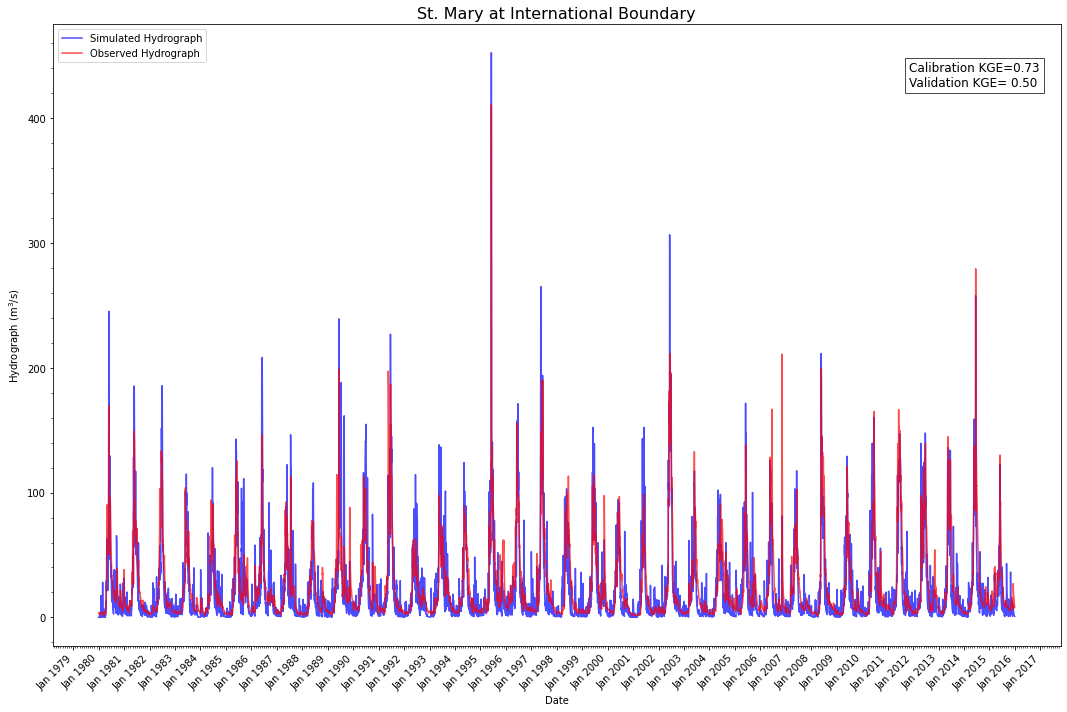

In [14]:
plot_hydrograph_with_precipitation(flow, rout, target_id,'01-01-1980','12-31-2015', '../../model/plots/SMRBB.png' )